In [19]:
from __future__ import annotations

from qamsi.strategies.scaling.volatility_targeting import VolatilityTargeting
from qamsi.strategies.heuristics.equally_weighted import EWStrategy
from qamsi.cov_estimators.cov_estimators import CovEstimators
from qamsi.utils.data import read_csv
from run import Dataset

REBAL_FREQ = "ME"
TOP_N = 30
DATASET = Dataset.TOPN_US
ESTIMATOR = CovEstimators.PRETRAINED.value(name="irl")
BASELINE = EWStrategy()

In [20]:
strategy_name = DATASET.name + ESTIMATOR.__class__.__name__ + f"_rebal{REBAL_FREQ}"
baseline_name = DATASET.name + BASELINE.__class__.__name__ + f"_rebal{REBAL_FREQ}"

strategy = read_csv(DATASET.value(topn=TOP_N).SAVE_PATH, strategy_name + ".csv")
baseline = read_csv(DATASET.value(topn=TOP_N).SAVE_PATH, baseline_name + ".csv")

In [21]:
strategy_excess_r = strategy["strategy_xs_r"]
baseline_excess_r = baseline["strategy_xs_r"]
rf = strategy["acc_rate"]

In [22]:
rebal_dates = strategy["rebal"]
rebal_dates = rebal_dates[rebal_dates].index

In [23]:
vol_scaler = VolatilityTargeting(
    trading_lag=1,
    max_exposure=2,
)
scaled_strategy_total_r = vol_scaler(
    strategy_excess_r=strategy_excess_r,
    rebal_dates=rebal_dates,
    baseline=baseline_excess_r,
).add(rf, axis=0)

In [24]:
from qamsi.backtest.assessor import Assessor

assessor = Assessor(
    rf_rate=rf,
    factors=strategy[strategy.columns.difference(["strategy_xs_r", "rebal", "acc_rate"])],
)

In [25]:
assessor(scaled_strategy_total_r)

StrategyStatistics:
* final_nav = 27.877238
* geom_avg_total_r = 0.191282
* geom_avg_xs_r = 0.171985
* std_xs_r = 0.224126
* min_xs_r = -0.123987
* max_xs_r = 0.204640
* skew = 0.416832
* kurtosis = 23.461910
* max_dd = -0.460548
* sharpe = 0.767357
* alpha_buy_hold = 0.101397
* tracking_error_buy_hold = 0.162123
* ir_buy_hold = 0.625429
* factor_loadings = {'low_risk': 0.7621144310304993, 'momentum': -0.13201664086379555, 'quality': 0.22002992737924448, 'size': 0.05327398564275101, 'spx': 1.0677892175117656, 'value': -0.291100851341475}
* alpha_benchmark = 0.073327
* alpha_benchmark_pvalue = 0.020312
* tracking_error_benchmark = 0.136160
* ir_benchmark = 0.538539
* ttest_pval = 0.101180
* levene_pval = 0.137230
* timing_ability_coef = -0.018303
* timing_ability_pval = 0.457303

In [26]:
assessor(baseline_excess_r + rf)

StrategyStatistics:
* final_nav = 6.285628
* geom_avg_total_r = 0.101514
* geom_avg_xs_r = 0.082217
* std_xs_r = 0.226559
* min_xs_r = -0.122205
* max_xs_r = 0.127455
* skew = -0.241644
* kurtosis = 10.460132
* max_dd = -0.604276
* sharpe = 0.362895
* alpha_buy_hold = 0.011629
* tracking_error_buy_hold = 0.045259
* ir_buy_hold = 0.256944
* factor_loadings = {'low_risk': -0.2920202932906375, 'momentum': 0.06438236302866211, 'quality': 0.02226121927403896, 'size': 0.027401459618944312, 'spx': 0.9264746534611608, 'value': 0.14664635585899263}
* alpha_benchmark = 0.017651
* alpha_benchmark_pvalue = 0.048284
* tracking_error_benchmark = 0.037069
* ir_benchmark = 0.476178
* ttest_pval = 0.427237
* levene_pval = 0.004384
* timing_ability_coef = -0.024532
* timing_ability_pval = 0.000622

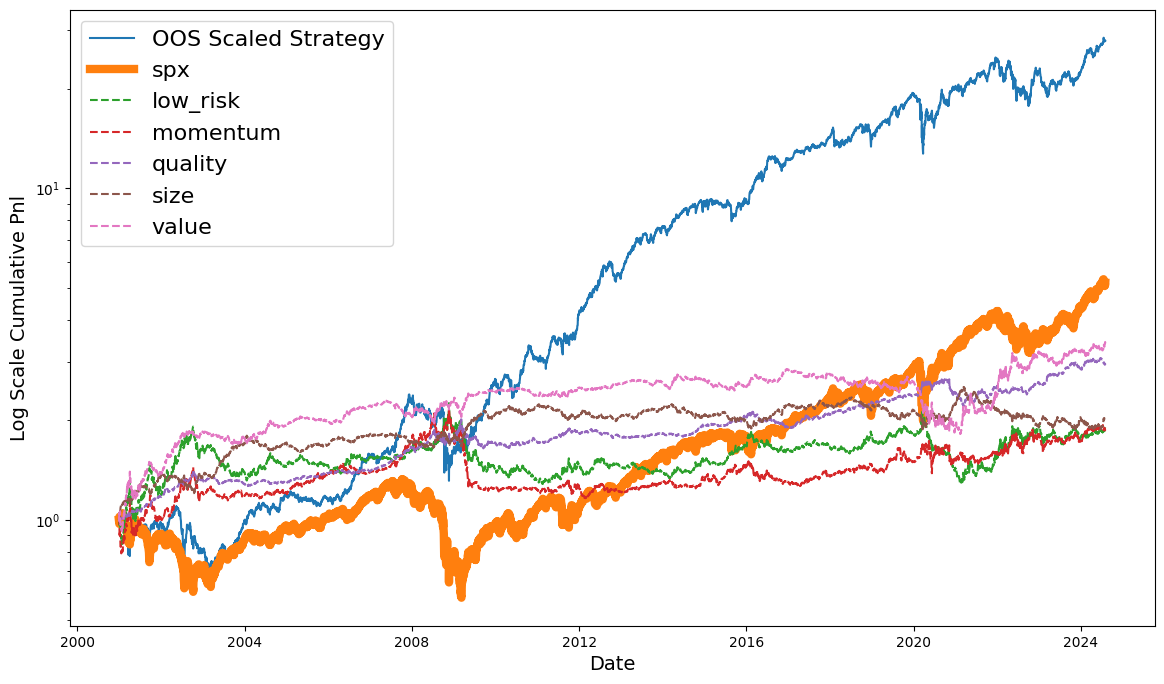

In [27]:
from qamsi.backtest.plot import plot_cumulative_pnls

plot_cumulative_pnls(
    strategy_total=scaled_strategy_total_r.to_frame("OOS Scaled Strategy"),
    buy_hold=strategy[strategy.columns.difference(["strategy_xs_r", "rebal", "acc_rate"])].add(rf, axis=0),
    plot_log=True,
    name_strategy="OOS Scaled Strategy",
    mkt_name="spx",
)